# Universal Knowledge Graph Prototype (GLiNER)

This notebook demonstrates how to build a knowledge graph from legal text (specifically Bills) using **GLiNER** (Generalist and Lightweight Named Entity Recognition).

## key Advantages of this Approach:
1. **Free & Local**: No API costs, runs on your machine.
2. **Custom Entities**: We can extract `Legislator`, `Committee`, `Statute` without training a new model.
3. **Unified Schema**: The labels we choose can be applied to Orders and Opinions later.

In [1]:
!pip install gliner networkx matplotlib tqdm -q

In [2]:
import json
import networkx as nx
import matplotlib.pyplot as plt
from gliner import GLiNER
from tqdm import tqdm
import os

## 1. Load Data
We load the `bills.json` file. We will process a sample of it to keep this prototype fast.

In [3]:
# Load bills data
target_file = 'bills.json'
with open(target_file, 'r') as f:
    raw_data = json.load(f)

In [4]:
data = []
if isinstance(raw_data, list):
        # If list of dicts, try to find 'text' or 'summary' user
    for item in raw_data: # LIMIT TO 20 FOR PROTOTYPE
        if 'chunk_text' in item:
            if isinstance(item['chunk_text'], dict):
                data.append({'text': item['chunk_text'].get('text', '')})
            else:
                data.append({'text': str(item['chunk_text'])})
        elif 'text' in item:
            data.append(item)
        elif 'summary' in item:
            data.append({'text': item['summary']})

## 2. Initialize GLiNER
We use `urchade/gliner_medium-v2.1` which is a good balance of speed and accuracy.

In [5]:
model = GLiNER.from_pretrained("urchade/gliner_medium-v2.1")

labels = [
    # People & Roles
    "Person", "Legislator", "Judge", 
    
    # Institutions
    "Committee", "Government Agency", "Court", "Organization",
    
    # Legal Docs
    "Bill", "Statute", "Case Citation", "Executive Order",
    
    # Context
    "Date", "Location", "Topic"
]

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

/Users/tanmayshubhgarg/Documents/Projects/LegalAI/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


gliner_config.json:   0%|          | 0.00/476 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/781M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/781M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/Users/tanmayshubhgarg/Documents/Projects/LegalAI/.venv/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


## 3. Build the Graph
We iterate through the text, extract entities, and create nodes/edges.

**Graph Schema:**
- **Chunk Node**: Represents the document fragment.
- **Entity Node**: Represents the extracted entity.
- **Edge**: `MENTIONS` (Chunk -> Entity).
- **Edge**: `CO_OCCURS` (Entity <-> Entity, if in same chunk).

In [6]:
G = nx.Graph()

for i, item in enumerate(tqdm(data)):
    text = item.get('text', '')
    if not text or len(text) < 50: continue
    
    # Create Chunk Node
    chunk_id = f"chunk_{i}"
    G.add_node(chunk_id, type="Chunk", text=text[:50]+"...")
    
    # Extract Entities
    entities = model.predict_entities(text, labels)
    
    entity_names = []
    for entity in entities:
        label = entity['label']
        name = entity['text']
        score = entity['score']
        
        # cleaning
        name = name.strip()
        
        # Add Entity Node
        G.add_node(name, type=label)
        
        # Edge: Chunk -> Entity
        G.add_edge(chunk_id, name, relation="MENTIONS")
        
        entity_names.append(name)
    
    # Edge: Entity <-> Entity (Co-occurrence)
    # This creates a dense web of relations
    import itertools
    for e1, e2 in itertools.combinations(entity_names, 2):
        if not G.has_edge(e1, e2):
            G.add_edge(e1, e2, relation="CO_OCCURS", weight=1)
        else:
            # Strengthen connection if they co-occur often
            G[e1][e2]['weight'] += 1

print(f"Graph constructed: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges.")

  0%|          | 1/9184 [00:06<16:01:04,  6.28s/it]/Users/tanmayshubhgarg/Documents/Projects/LegalAI/.venv/lib/python3.10/site-packages/gliner/data_processing/processor.py:372: UserWarning: Sentence of length 2381 has been truncated to 384
  batch = [self.preprocess_example(b["tokenized_text"], b[key], class_to_ids) for b in batch_list]
  0%|          | 3/9184 [00:07<4:29:18,  1.76s/it] /Users/tanmayshubhgarg/Documents/Projects/LegalAI/.venv/lib/python3.10/site-packages/gliner/data_processing/processor.py:372: UserWarning: Sentence of length 460 has been truncated to 384
  batch = [self.preprocess_example(b["tokenized_text"], b[key], class_to_ids) for b in batch_list]
  0%|          | 5/9184 [00:08<2:35:43,  1.02s/it]/Users/tanmayshubhgarg/Documents/Projects/LegalAI/.venv/lib/python3.10/site-packages/gliner/data_processing/processor.py:372: UserWarning: Sentence of length 576 has been truncated to 384
  batch = [self.preprocess_example(b["tokenized_text"], b[key], class_to_ids) for b i

Graph constructed: 24351 nodes, 170110 edges.


## 4. Visualize
Basic visualization to inspect the clusters.

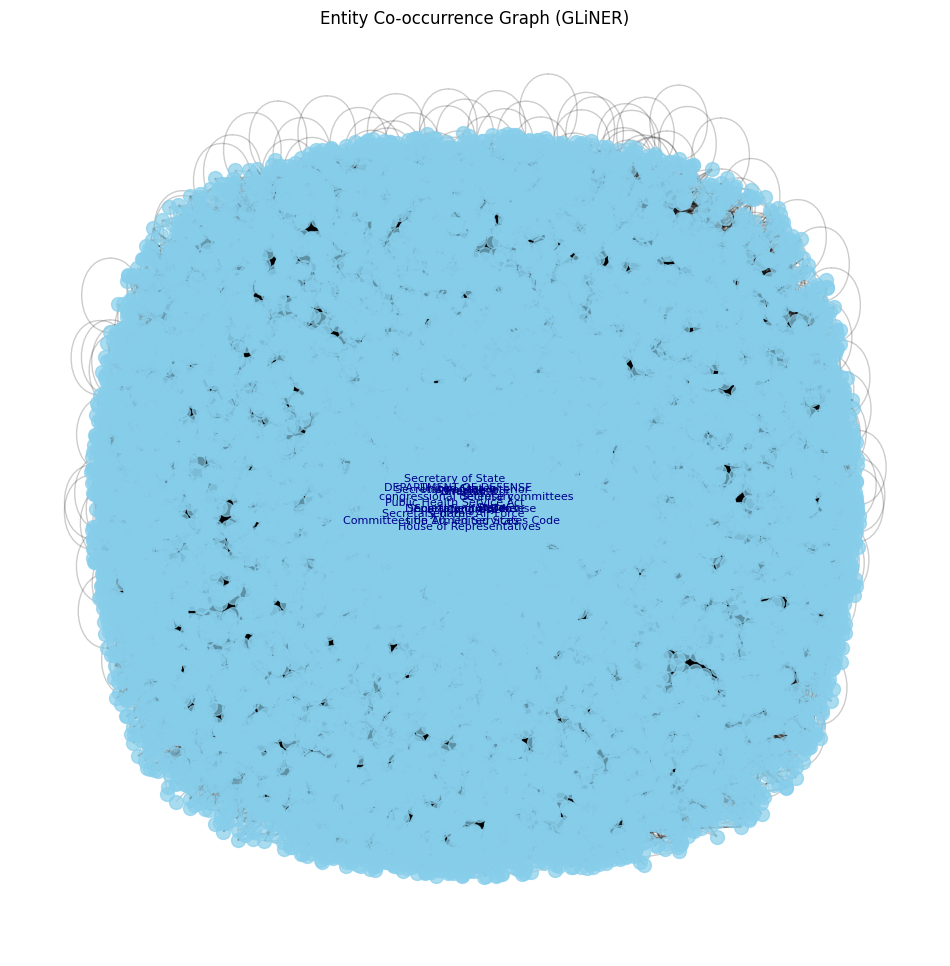

In [7]:
plt.figure(figsize=(12, 12))

# Filter out Chunk nodes for cleaner visualization (just show Entity Network)
entity_nodes = [n for n, attr in G.nodes(data=True) if attr['type'] != 'Chunk']
subgraph = G.subgraph(entity_nodes)

if len(subgraph.nodes()) > 0:
    pos = nx.spring_layout(subgraph, k=0.15, iterations=20)
    
    # Draw nodes
    # Color by type if possible, for now just generic
    nx.draw_networkx_nodes(subgraph, pos, node_size=100, node_color="skyblue", alpha=0.7)
    
    # Draw edges
    nx.draw_networkx_edges(subgraph, pos, alpha=0.2)
    
    # Draw labels (only for high degree nodes to avoid clutter)
    final_labels = {}
    degrees = dict(subgraph.degree())
    top_nodes = sorted(degrees, key=degrees.get, reverse=True)[:20]
    for node in top_nodes:
        final_labels[node] = node
        
    nx.draw_networkx_labels(subgraph, pos, labels=final_labels, font_size=8, font_color="darkblue")
    
    plt.title("Entity Co-occurrence Graph (GLiNER)")
    plt.axis('off')
    plt.show()
else:
    print("Not enough entity nodes to visualize.")

In [8]:
# Save graph for future use
nx.write_gexf(G, "bills_knowledge_graph.gexf")
print("Graph saved to bills_knowledge_graph.gexf")

Graph saved to bills_knowledge_graph.gexf
